In [1]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
from PIL import Image
import random


In [41]:
data_dir = 'Train'

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset='training', seed=123, image_size=(224, 224), batch_size=120)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset='validation', seed=123, image_size=(224, 224), batch_size=120)

#apple_dir = 'Use'
#apple_dir = 'Use1'
apple_dir = 'Use2'
#apple_dir = 'Use3'

apple_ds = tf.keras.utils.image_dataset_from_directory(
    apple_dir, image_size=(224, 224), labels = None)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 382 files belonging to 4 classes.
Using 306 files for training.
Found 382 files belonging to 4 classes.
Using 76 files for validation.
Found 80 files belonging to 1 classes.


In [3]:
# Preprocess:

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Rescale:
tf.keras.layers.Rescaling(scale=1./255)

# Add augmentation:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)])

In [4]:

img_height = 224
img_width = 224
IMG_SIZE = img_width, img_height
IMG_SHAPE = IMG_SIZE + (3,)

# Create the base model from the pre-trained model MobileNet V2

# Model van MobileNet
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# base_model.summary()

In [5]:
base_model.trainable = False

In [6]:
# Feature extraction

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(120, 7, 7, 1280)
(120, 1280)


In [7]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(120, 4)


In [8]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = tf.keras.layers.Rescaling(scale=1./255)(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)

modelX = tf.keras.Model(inputs, outputs)

In [9]:
#optimaliseren
base_learning_rate = 0.0001
modelX.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

modelX.summary()

len(modelX.trainable_variables)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124  

2

In [10]:
initial_epochs = 25

loss0, accuracy0 = modelX.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

1/1 [==============================] - 2s 2s/step - loss: 1.5130 - accuracy: 0.4079
initial loss: 1.51
initial accuracy: 0.41


In [11]:
history = modelX.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/25
3/3 [==============================] - 6s 1s/step - loss: 1.7099 - accuracy: 0.3235 - val_loss: 1.4566 - val_accuracy: 0.4211
Epoch 2/25
3/3 [==============================] - 4s 1s/step - loss: 1.6393 - accuracy: 0.3235 - val_loss: 1.4080 - val_accuracy: 0.4342
Epoch 3/25
3/3 [==============================] - 4s 1s/step - loss: 1.6432 - accuracy: 0.3399 - val_loss: 1.3666 - val_accuracy: 0.4605
Epoch 4/25
3/3 [==============================] - 4s 1s/step - loss: 1.5660 - accuracy: 0.3137 - val_loss: 1.3304 - val_accuracy: 0.4868
Epoch 5/25
3/3 [==============================] - 5s 2s/step - loss: 1.5519 - accuracy: 0.3366 - val_loss: 1.2994 - val_accuracy: 0.4737
Epoch 6/25
3/3 [==============================] - 5s 2s/step - loss: 1.4981 - accuracy: 0.3660 - val_loss: 1.2737 - val_accuracy: 0.4737
Epoch 7/25
3/3 [==============================] - 5s 2s/step - loss: 1.4886 - accuracy: 0.3268 - val_loss: 1.2525 - val_accuracy: 0.4868
Epoch 8/25
3/3 [=========================

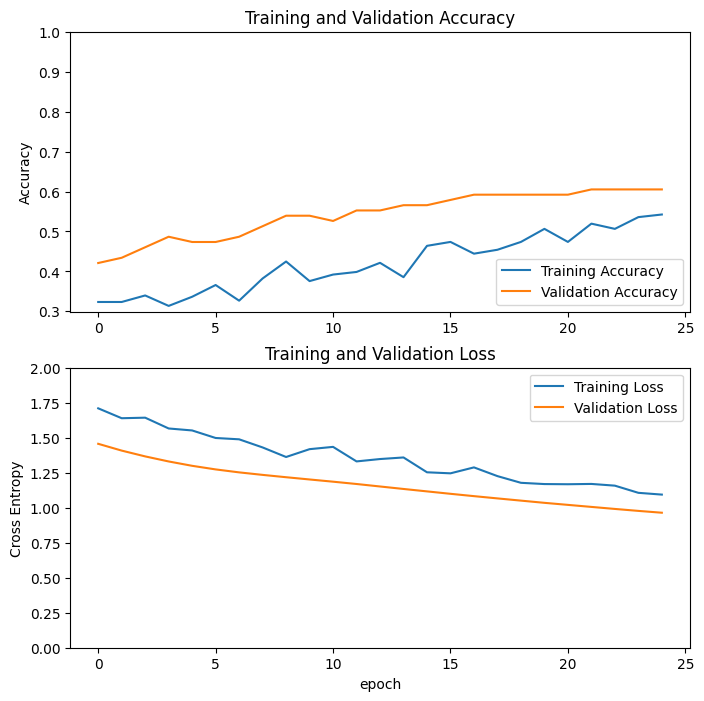

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
# Unfreeze
# MobileNet

base_model.trainable = True

In [14]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [15]:
modelX.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

modelX.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124  

In [16]:
len(modelX.trainable_variables)
#vanaf 100 dus 100 ook en 154 ook

56

In [17]:
# Continue training

fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = modelX.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 25/40
3/3 [==============================] - 10s 2s/step - loss: 1.0093 - accuracy: 0.5915 - val_loss: 0.7497 - val_accuracy: 0.7500
Epoch 26/40
3/3 [==============================] - 7s 2s/step - loss: 0.7540 - accuracy: 0.7026 - val_loss: 0.6535 - val_accuracy: 0.7895
Epoch 27/40
3/3 [==============================] - 7s 2s/step - loss: 0.6364 - accuracy: 0.7484 - val_loss: 0.6012 - val_accuracy: 0.8158
Epoch 28/40
3/3 [==============================] - 7s 2s/step - loss: 0.5581 - accuracy: 0.8105 - val_loss: 0.5096 - val_accuracy: 0.7895
Epoch 29/40
3/3 [==============================] - 7s 2s/step - loss: 0.4855 - accuracy: 0.8366 - val_loss: 0.4882 - val_accuracy: 0.8421
Epoch 30/40
3/3 [==============================] - 7s 2s/step - loss: 0.4360 - accuracy: 0.8529 - val_loss: 0.4487 - val_accuracy: 0.8684
Epoch 31/40
3/3 [==============================] - 7s 2s/step - loss: 0.3616 - accuracy: 0.8954 - val_loss: 0.4031 - val_accuracy: 0.8289
Epoch 32/40
3/3 [================

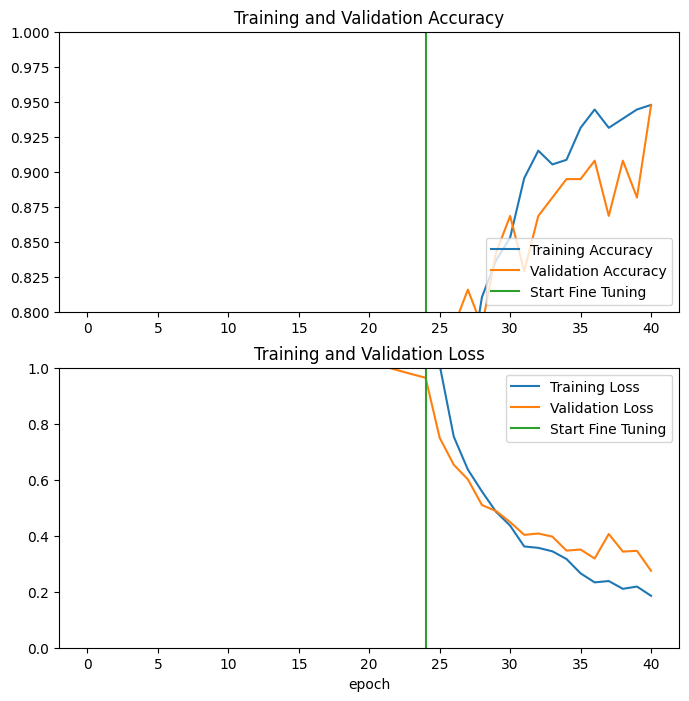

In [18]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
#Evaluatie van eigen model
modelX.evaluate(test_ds)

1/1 [==============================] - 1s 1s/step - loss: 0.7050 - accuracy: 0.7417


[0.7050468325614929, 0.7416666746139526]

Found 120 files belonging to 4 classes.


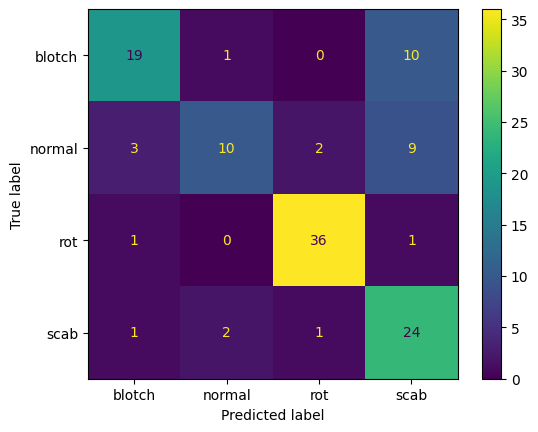

In [22]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay

# test_ds Aanmaken
# andere images dan in train_ds

data_dir = 'test'

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, seed=123, image_size=(224, 224),shuffle = False, batch_size=120)

batchPredictions = modelX.predict(test_ds)

predicted_categories = tf.argmax(batchPredictions, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0)

cm = confusion_matrix(true_categories, predicted_categories)

cmd = ConfusionMatrixDisplay(cm, display_labels=['blotch','normal','rot','scab'])

cmd.plot()

In [ ]:
modelx.save('models/mobilenetv2')

In [42]:
batchPredictions = modelX.predict(apple_ds)

predicted_categories = tf.argmax(batchPredictions, axis=1)
print(predicted_categories)

tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1], shape=(80,), dtype=int64)


In [43]:
predicted_categories[0]
predicted_categories[0].numpy().tolist()
samplebatchnp = predicted_categories.numpy()
samplebatchlist = samplebatchnp.tolist()
print(samplebatchlist)
print(samplebatchlist.count(0))
print(samplebatchlist.count(1))
print(samplebatchlist.count(2))
print(samplebatchlist.count(3))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0
80
0
0


In [38]:
aqlset_list =(random.choices(samplebatchlist,k = 80))
print(aqlset_list)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 1, 2, 2, 2, 3, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2]


In [39]:
blotchApple = aqlset_list.count(0)
HealtyApple = aqlset_list.count(1)
rotApple = aqlset_list.count(2)
scabApple = aqlset_list.count(3)

def AQLTestscore():

    for apple in aqlset_list:
        
        if HealtyApple >=79:
            print (f'The batch has been quallified as: Class 1\n')
        elif HealtyApple >=75:
            print (f'The batch has been quallified as: Class 2\n')
        elif HealtyApple >=73:
            print (f'The batch has been quallified as: Class 3\n')
        else:
            print (f'The batch has been rejected\n')

        print (f'The total batch of {len(aqlset_list)} apples consists of:\n'
        f'Healthy apples: {HealtyApple}\n'
        f'Blotch apples: {blotchApple}\n'
        f'Rot apples: {rotApple}\n'
        f'Scab apples: {scabApple}\n')
        break
    
AQLTestscore()

The batch has been rejected

The total batch of 80 apples consists of:
Healthy apples: 11
Blotch apples: 0
Rot apples: 63
Scab apples: 6



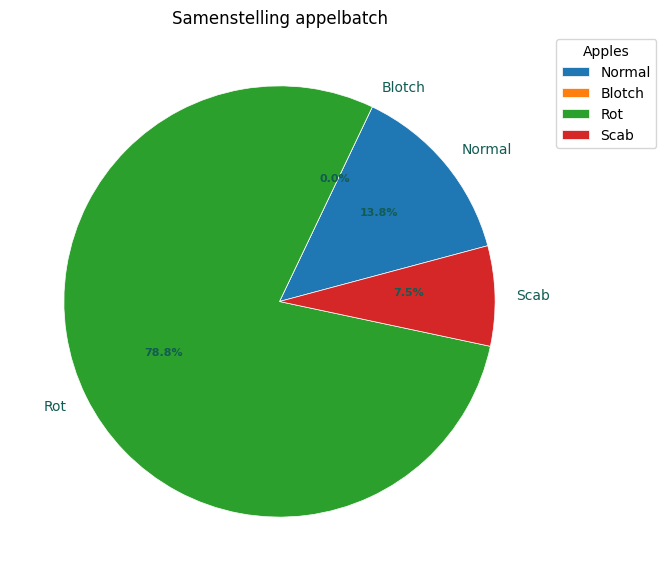

In [40]:
# Creating dataset
appleLabels = ['Normal', 'Blotch', 'Rot', 'Scab']
 
data = [HealtyApple, blotchApple, rotApple, scabApple]

# Creating explode data
explode = (0.0, 0.0, 0.0, 0.0) # not necessary

# Wedge properties
wp = { 'linewidth' : 0.5, 'edgecolor' : "white" }

# Creating autocpt arguments
def func(pct, allvalues):
	absolute = int(pct / 100.*np.sum(allvalues))
	return "{:.1f}%\n".format(pct, absolute)

# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(data,
								autopct = lambda pct: func(pct, data),
								explode = explode,
								labels = appleLabels,
								shadow = False,
								startangle = 15,
								wedgeprops = wp,
								textprops = dict(color ="#115C53"))

# Adding legend
ax.legend(wedges, appleLabels,
		title ="Apples",
		loc ="upper left",
		bbox_to_anchor =(1, 0, 0.5, 1))

plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Samenstelling appelbatch") # add Classification as title

#show plot
plt.show() 

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L12-v2')


accuracyBatch = modelX.evaluate(apple_ds)

sentences = [f'There are {HealtyApple} healthy apples in this batch',
                                  f'The accuracy of this prediction is {accuracyBatch} for loss and accuracyS',
                                  f'This batch contains {rotApple} rotten apple(s)',
                                  f'This batch contains {scabApple} scabbed apple(s)',
                                  f'This batch contains {blotchApple} blotched apple(s)',
                                    'Class 1 are 79 healty apples for example supermarkets ore greengrocer',
                                    'Class 2 are 75 healty apples used for exapmle in applesause',
                                    'Class 3 are 73 healty apples used for syrup',
                                    'A rejected batch can be used for petfood',
                                    'We have 4 types of apples, Blotch, Normal, Rot and Scab',
                                    'A batch consists of 80 apples',
                                    'Am I so smart ore are you so dum',
                                    'AQL means Acceptance Quality limit',
                                    'The lot size is between 5.000 and 10.000 apples']


query_embedding = model.encode(input('what is your question?'), convert_to_tensor=True)
passage_embedding = model.encode(sentences, convert_to_tensor=True)
answerArray = util.dot_score(query_embedding, passage_embedding)

print("Similarity:", answerArray)

answerLocation = answerArray.argmax()

print(sentences[answerLocation.item()])